Import modules, dataset download

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import kagglehub
import spacy
import nltk
import os
import re

path = kagglehub.dataset_download("pashupatigupta/emotion-detection-from-text")
emotion_dataset = pd.read_csv(os.path.join(path, "tweet_emotions.csv"))



Text preprocessing. Tweets cleaning, lemmatization

In [36]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")

emotion_dataset['cleaned_text'] = emotion_dataset['content'].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))
emotion_dataset['cleaned_text'] = emotion_dataset['cleaned_text'].apply(
    lambda x: ' '.join(word for word in x.split() if word not in stop_words)
)
emotion_dataset['lemmatized_text'] = emotion_dataset['cleaned_text'].apply(
    lambda x: ' '.join([token.lemma_ for token in nlp(x)])
)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dendo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Vectoryze text

In [37]:
vectorizer = TfidfVectorizer(max_features=500)
X = vectorizer.fit_transform(emotion_dataset['lemmatized_text'])

tokens = emotion_dataset['lemmatized_text'].apply(lambda x: x.split())
w2v_model = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=1)

Multinomeal model creating, learning based on TF-IDF vectors.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, emotion_dataset['sentiment'], test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.32675


LogisticalRegression model creating, learning based on Word2Vec vectors.

In [50]:
def get_vector(sentence):
    valid_words = [w2v_model.wv[word] for word in sentence if word in w2v_model.wv]
    if valid_words:
        return np.mean(valid_words, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

X_w2v = np.array([get_vector(sentence) for sentence in tokens])

X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_w2v, emotion_dataset['sentiment'], test_size=0.2, random_state=42)

model_w = LogisticRegression(max_iter=1000)
model_w.fit(X_train_w, y_train_w)
y_pred_w = model_w.predict(X_test_w)
print("Accuracy:", accuracy_score(y_test, y_pred_w))


Accuracy: 0.292


Some predictions for TF-IDF vectorization with MultinomialNB model

In [51]:
for i in range(5):
    print(f"Text: {emotion_dataset['content'].iloc[i]}")
    print(f"Real emotion: {emotion_dataset['sentiment'].iloc[i]}")
    print(f"Predicted label: {y_pred[i]}")

Text: @tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[
Real emotion: empty
Predicted label: happiness
Text: Layin n bed with a headache  ughhhh...waitin on your call...
Real emotion: sadness
Predicted label: worry
Text: Funeral ceremony...gloomy friday...
Real emotion: sadness
Predicted label: neutral
Text: wants to hang out with friends SOON!
Real emotion: enthusiasm
Predicted label: neutral
Text: @dannycastillo We want to trade with someone who has Houston tickets, but no one will.
Real emotion: neutral
Predicted label: neutral


Some predictions for Word2Vec vectorization with LogisticRegression model

In [52]:
for i in range(5):
    print(f"Text: {emotion_dataset['content'].iloc[i]}")
    print(f"Real emotion: {emotion_dataset['sentiment'].iloc[i]}")
    print(f"Predicted label: {y_pred_w[i]}")

Text: @tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[
Real emotion: empty
Predicted label: happiness
Text: Layin n bed with a headache  ughhhh...waitin on your call...
Real emotion: sadness
Predicted label: worry
Text: Funeral ceremony...gloomy friday...
Real emotion: sadness
Predicted label: neutral
Text: wants to hang out with friends SOON!
Real emotion: enthusiasm
Predicted label: neutral
Text: @dannycastillo We want to trade with someone who has Houston tickets, but no one will.
Real emotion: neutral
Predicted label: neutral


Visualization of confusion matrix for MultinomialNB model with TF-IDF vectorization

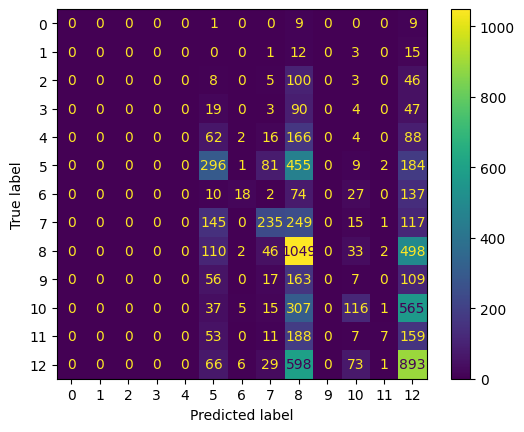

In [53]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

Visualization of confusion matrix for LogisticRegression model with Word2Vec vectorization 

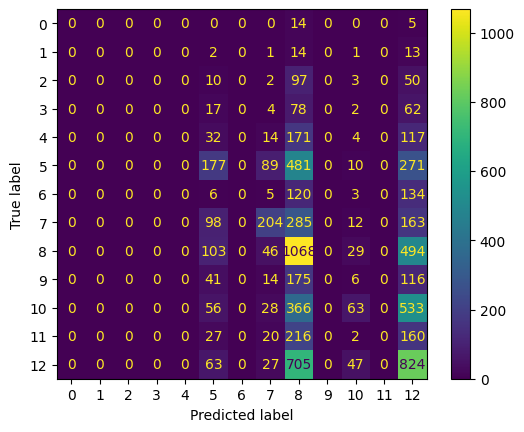

In [54]:
cm = confusion_matrix(y_test_w, y_pred_w)
ConfusionMatrixDisplay(cm).plot()

Conclusion

За результатами експерименту, точність моделі з векторизацією TF-IDF склала 0.32675, що є вищим результатом порівняно з моделлю на основі Word2Vec, де точність досягла 0.292. Це свідчить про те, що в даному випадку векторизація TF-IDF виявилася більш ефективною для задачі класифікації емоцій в текстах, ніж використання попередньо навченої моделі Word2Vec.